In [1]:
# !python --version
# !pip --version

In [2]:
# !pip install wget
# !mkdir ./dataset
# !mkdir ./model
# !wget -nc -P ./dataset https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip -o ./dataset/ml-latest-small.zip -d ./dataset

In [3]:
# !pip install torch torch_geometric numpy matplotlib seaborn pandas
# !pip install scikit-learn

In [4]:
import pandas as pd

file_path = './dataset/ml-latest-small/'
batch_size = 64
train_percentage = 80
val_percentage = 10
test_percentage = 10
num_epochs = 50

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
ratings = pd.read_csv(file_path + 'ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies = pd.read_csv(file_path + 'movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Genres from string separated by '|' to list of strings

In [7]:
dataset = ratings.merge(movies, left_on='movieId', right_on='movieId', how='left')

dataset['genres'] = dataset['genres'].apply(lambda x: x.split('|'))
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]"
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"


In [8]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

logging.info(f"Number of unique users: {num_users}")
logging.info(f"Number of unique movies: {num_movies}")

2024-11-18 18:33:25,181 - INFO - Number of unique users: 610
2024-11-18 18:33:25,181 - INFO - Number of unique movies: 9724


Create columns for each genre, if movie in that genre 0, otherwise 1

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

genre_matrix = mlb.fit_transform(dataset['genres'])

genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

dataset = pd.concat([dataset, genre_df], axis=1)

dataset.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [10]:
user_mapping = {id: idx for idx, id in enumerate(dataset['userId'].unique())}
movie_mapping = {id: idx for idx, id in enumerate(dataset['movieId'].unique())}

dataset['userId'] = dataset['userId'].map(user_mapping)
dataset['movieId'] = dataset['movieId'].map(movie_mapping)

In [11]:
from sklearn.model_selection import train_test_split

if train_percentage + val_percentage + test_percentage != 100:
    raise ValueError("The sum of train, val, and test percentages must be 100.")

try:
    train_data, test_data = train_test_split(dataset, test_size=test_percentage / 100, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=val_percentage / (train_percentage + val_percentage), random_state=42)
except ValueError as e:
    logging.critical(f"Error in data splitting: {e}")
    raise

logging.info(f"Training data: {len(train_data)} entries")
logging.info(f"Validation data: {len(val_data)} entries")
logging.info(f"Test data: {len(test_data)} entries")

2024-11-18 18:33:25,616 - INFO - Training data: 90752 entries
2024-11-18 18:33:25,616 - INFO - Validation data: 8963 entries
2024-11-18 18:33:25,617 - INFO - Test data: 1121 entries


In [12]:
train_data.to_csv('./dataset/train_data.csv', index=False)
val_data.to_csv('./dataset/val_data.csv', index=False)
test_data.to_csv('./dataset/test_data.csv', index=False)

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

2024-11-18 18:33:27,220 - INFO - Using device: cuda


In [14]:
from torch.utils.data import Dataset, DataLoader

class RatingsDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['userId'].values, dtype=torch.long)
        self.movies = torch.tensor(data['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [15]:
train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)
test_dataset = RatingsDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
import torch.nn as nn

class GraphRecommendationModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(GraphRecommendationModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        # Additional layers like GCN can be added here
        self.fc = nn.Linear(embedding_dim, 1)
        
    def forward(self, user_indices, movie_indices):
        user_embeds = self.user_embedding(user_indices)
        movie_embeds = self.movie_embedding(movie_indices)
        interaction = user_embeds * movie_embeds
        output = self.fc(interaction)
        return output

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [18]:
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

criterion = RMSELoss()

patience = 10
best_model = None
best_params = None

# Parameter Grid for Grid Search
param_grid = {
    'embedding_dim': [64, 128, 256],
    'learning_rate': [0.001, 0.0001, 0.0001]
}


train_losses = []
val_losses = []

for params in ParameterGrid(param_grid):
    logging.info(f"Current: {params}")
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    model = GraphRecommendationModel(num_users, num_movies, params['embedding_dim']).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])
    
    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(num_epochs):  # Max epochs
        model.train()
        train_loss = 0
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            
            optimizer.zero_grad()
            outputs = model(users, movies).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for users, movies, ratings in val_loader:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                outputs = model(users, movies).squeeze()
                loss = criterion(outputs, ratings)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        logging.info(f"Epoch {epoch+1}: Train Loss: {train_loss}, Val Loss: {val_loss}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model = model
            best_params = params
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            logging.info("Early stopping triggered.")
            break
    
    train_losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)

2024-11-18 18:33:27,269 - INFO - Current: {'embedding_dim': 64, 'learning_rate': 0.001}
2024-11-18 18:33:29,825 - INFO - Epoch 1: Train Loss: 3.011010006217257, Val Loss: 2.348856679936673
2024-11-18 18:33:31,578 - INFO - Epoch 2: Train Loss: 1.8146076663088564, Val Loss: 1.352817011217699
2024-11-18 18:33:33,346 - INFO - Epoch 3: Train Loss: 1.1422185352221867, Val Loss: 1.06078451026416
2024-11-18 18:33:35,083 - INFO - Epoch 4: Train Loss: 1.035246585084622, Val Loss: 1.0541596104067268
2024-11-18 18:33:36,883 - INFO - Epoch 5: Train Loss: 1.023942757812979, Val Loss: 1.0644080858704046
2024-11-18 18:33:38,632 - INFO - Epoch 6: Train Loss: 1.0046422306674156, Val Loss: 1.0744653935973525
2024-11-18 18:33:40,397 - INFO - Epoch 7: Train Loss: 0.9741706712373726, Val Loss: 1.0925505833422884
2024-11-18 18:33:42,150 - INFO - Epoch 8: Train Loss: 0.9336241286967806, Val Loss: 1.1093201996586848
2024-11-18 18:33:43,917 - INFO - Epoch 9: Train Loss: 0.8858850734946758, Val Loss: 1.125616193

In [19]:
logging.info(f"Best Parameters: {best_params}")

2024-11-18 18:43:09,667 - INFO - Best Parameters: {'embedding_dim': 256, 'learning_rate': 0.0001}


In [20]:
best_index = list(ParameterGrid(param_grid)).index(best_params)
best_train_losses = train_losses[best_index]
best_val_losses = val_losses[best_index]

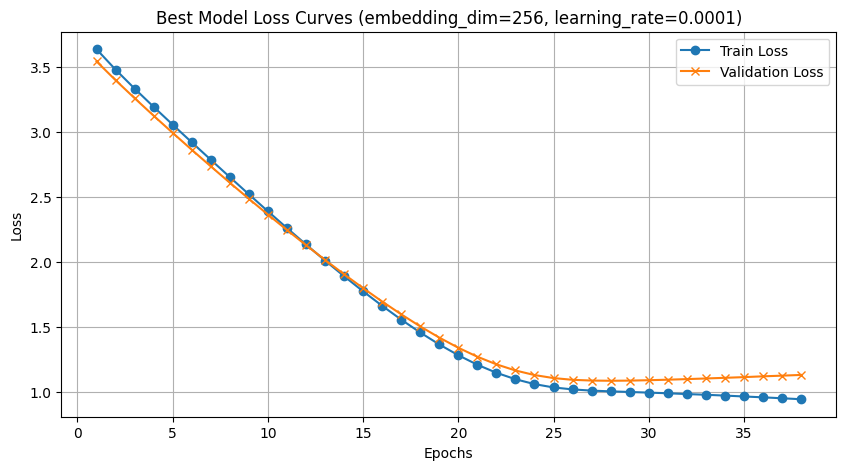

In [21]:
import matplotlib.pyplot as plt

# Plot the loss curves for the best model
epochs = list(range(1, len(best_train_losses) + 1))
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.plot(epochs, best_train_losses, label="Train Loss", marker='o')
# Plotting validation loss
plt.plot(epochs, best_val_losses, label="Validation Loss", marker='x')

# Adding titles and labels
plt.title(f"Best Model Loss Curves (embedding_dim={best_params['embedding_dim']}, learning_rate={best_params['learning_rate']})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model = GraphRecommendationModel(num_users, num_movies, best_params['embedding_dim']).to(device)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_loss = 0.0
test_corrects = 0
true_ratings = []
predicted_ratings = []

with torch.no_grad():
    for users, movies, ratings in test_loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        test_loss += loss.item()
        true_ratings.extend(ratings.cpu().numpy())
        predicted_ratings.extend(outputs.cpu())

test_loss /= len(test_loader)

logging.info(f"RMSE Loss: {test_loss}")

2024-11-18 18:43:10,047 - INFO - RMSE Loss: 1.0856525037023756


In [25]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

true_ratings = np.array(true_ratings)
predicted_ratings = np.array(predicted_ratings)

# Binarize ratings for precision, recall, and F1 score
threshold = 3.5
true_labels = (true_ratings >= threshold).astype(int)
predicted_labels = (predicted_ratings >= threshold).astype(int)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

logging.info(f"Precision: {precision}")
logging.info(f"Recall: {recall}")
logging.info(f"F1 Score: {f1_score}")

2024-11-18 18:45:16,927 - INFO - Precision: 0.5980861244019139
2024-11-18 18:45:16,927 - INFO - Recall: 0.37425149700598803
2024-11-18 18:45:16,927 - INFO - F1 Score: 0.4604051565377532


In [26]:
def ndcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    dcg = np.sum((2 ** y_true - 1) / np.log2(np.arange(2, y_true.size + 2)))
    ideal_dcg = np.sum((2 ** np.sort(y_true)[::-1] - 1) / np.log2(np.arange(2, y_true.size + 2)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0


ndcg_scores = [ndcg_score(true_ratings, predicted_ratings) for _ in range(len(test_loader))]
average_ndcg = np.mean(ndcg_scores)

logging.info(f"NDCG: {average_ndcg}")

2024-11-18 18:45:17,503 - INFO - NDCG: 0.8046837771891568
